In [1]:
import warnings
warnings.simplefilter(action='ignore')

import matplotlib.pyplot as plt
import pandas as pd
import os
import nltk
from nltk.stem.snowball import EnglishStemmer
import cv2

nrows = None

# nltk.download()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Preprocess text

In [2]:
stemmer = EnglishStemmer()
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_words = [stemmer.stem(w) for w in list(nltk.corpus.stopwords.words('english'))]

def clean_up(text):
    text = ''.join(c for c in text if not c.isdigit())
    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [w for w in tokens if not w in stop_words]
    return " ".join(tokens)

def get_negative_comments(comments):
    negative_comments = comments[comments["stars"]<3]["text"].to_list()

    for comment_id in range(len(negative_comments)):
        negative_comments[comment_id] = negative_comments[comment_id].replace('\n', ' ')
        
    return negative_comments


In [3]:
filename = './yelp_dataset/yelp_academic_dataset_review.json'
chunksize = 64

def tokenize_comments():
    c=0
    for comments in pd.read_json(filename, lines=True, chunksize=chunksize):
        negative_comments = get_negative_comments(comments)
        tokenized_text = [*map(clean_up, negative_comments)]
        res_df = pd.DataFrame(data=tokenized_text, columns=['tokenized_text'])
        if c:
            res_df.to_csv('preprocessed_text.csv', mode='a', index=False, header=False)
        else:
            res_df.to_csv('preprocessed_text.csv', mode='a', index=False)
            c=1

# tokenize_comments()


In [4]:
t_filename = './preprocessed_text.csv'

# df = pd.read_csv(t_filename)

In [5]:
def get_most_used():
    freqs = {}
    tokenized_text = df["tokenized_text"].to_list()
    for comment in tokenized_text:
        if isinstance(comment, str):
            comment = comment.split()
            for word in list(set(comment)):
                if word in freqs:
                    freqs[word] += 1
                else:
                    freqs[word] = 1

    freqs_list = [(x, freqs[x]/df.shape[0])for x in freqs]
    freqs_list = sorted(freqs_list, key=lambda x:x[1])[::-1]

    out = [x[0]for x in freqs_list[:500]]

    with open("most_used.txt", "w+") as f:
        for w in out:
            f.write(w)
            f.write('\n') 
            
# get_most_used()


In [6]:
n_frequent = []

with open("most_used.txt", "r") as f:
    for l in f:
        n_frequent.append(l[:-1])

n_frequent = n_frequent[:100]

def clear_words(tokens):
    if isinstance(tokens, str):
        return " ".join([w for w in tokens.split() if not w in n_frequent])
    else:
        return ""


def del_most_freq():
    global df
    df = df.dropna()
    df["tokenized_text"] = df["tokenized_text"].apply(clear_words)
    df.to_csv('preprocessed_reviews.csv', index=False)
    
# del_most_freq()

In [7]:
def remove_na():
    filename = './preprocessed_reviews.csv'
    comments = pd.read_csv(filename)
    comments = comments.dropna()
    comments.to_csv('preprocessed_reviews.csv', index=False)

# remove_na()

#### Exemple

In [9]:
ex_text = "I've stayed at many Marriott and Renaissance Marriott's and this was a huge disappointment! The front desk and atrium is nice..there is a starbucks on site which is nice. The rooms are run down and old. There is a flat screen but that is to be expected of a Renaissance. We got this hotel via Priceline at a rate of $75/night...good deal for the price but this is not a true Renaissance."
print(f"Original: {ex_text}\n")
ex_text = clean_up(ex_text).replace('\n', ' ')
print(f"Texte nettoyé: {ex_text}\n")
ex_text = clear_words(ex_text)
print(f"mots fréquents supprimés: {ex_text}")



Original: I've stayed at many Marriott and Renaissance Marriott's and this was a huge disappointment! The front desk and atrium is nice..there is a starbucks on site which is nice. The rooms are run down and old. There is a flat screen but that is to be expected of a Renaissance. We got this hotel via Priceline at a rate of $75/night...good deal for the price but this is not a true Renaissance.

Texte nettoyé: stay mani marriott renaiss marriott huge disappoint front desk atrium nice starbuck site nice room run old flat screen expect renaiss got hotel via pricelin rate night good deal price true renaiss

mots fréquents supprimés: stay mani marriott renaiss marriott huge front desk atrium starbuck site room run old flat screen expect renaiss hotel via pricelin rate night deal true renaiss


# Preprocess images

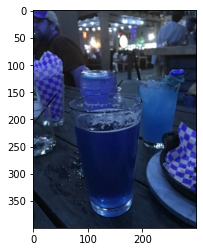

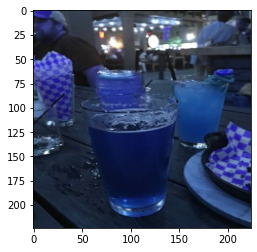

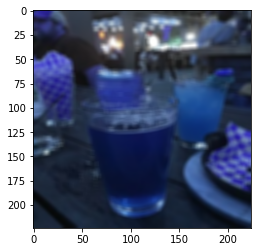

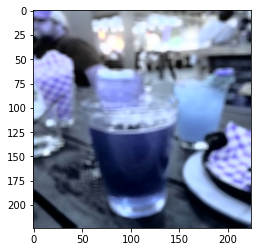

In [90]:
def hisEqulColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    channels=cv2.split(ycrcb)
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
    return img

def preprocess_imgs():
    save_path = "preprocessed_imgs"
    pictures = pd.read_json("photos.json", lines=True, nrows=nrows)[["photo_id"]]
    done = 1
    for index, row in pictures.iterrows():
        img = cv2.imread(os.path.join("./yelp_photos", f"{row['photo_id']}.jpg"), -1)
        img = cv2.resize(img, (224, 224)) # resize to vgg16 input size
        img = cv2.blur(img,(5, 5)) # apply gaussian blur
        img = hisEqulColor(img) # equalize histogram
        cv2.imwrite(os.path.join(save_path, f"{row['photo_id']}.jpg"), img) # save image
        if not done % 1000:
            print(f"Done {done}/200 000")
        done += 1
        
# preprocess_imgs()